# Stock Price Indicator
## I. ETL Pipeline Preparation
### 1. Import libraries and load datasets.
- Import Python libraries
- Load data from Yahoo Finance (Accessing data from the Yahoo finance plattform via the corresponing API you are able to download data since 1950 (if the stock existed))

In [321]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf

from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [411]:
# Import data from Yahoo finance

def get_data(symbols=['SPY'], start_date='2020-01-01', end_date='2020-12-31'):
    '''
    Setup of an empty dataframe with the given timeperiod as index to be used as instance for further gathered data.
    Then downloads the data from Yahoo Finance for the selected symbol(s) and time period and selects the Adj Close column
    INPUT: 
    symbols - list - symbols of listed stocks
    start_date - datetime - Beginning of the period to analyze
    end_date - datetime - End of the period to analyze
    
    OUTPUT
    df - dataframe - Dataframe containing the Adj Close for each symbol with the time period as index (ordered ascending)
    '''
    dates= pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    
    for symbol in symbols:
        df_tmp = yf.download(symbol, start_date, end_date)
        df_tmp = df_tmp[['Adj Close']]
        df_tmp = df_tmp.rename(columns={"Adj Close": symbol})
        
        df = df.join(df_tmp)
        df = df.dropna()
    
    return df

In [412]:
data_analysis_df = get_data(symbols=['BABA', 'VZ','GOLD', 'BIIB'], start_date='2020-01-01', end_date='2021-04-16')
data_analysis_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BABA,VZ,GOLD,BIIB
2020-01-02,219.770004,57.256145,18.166582,294.239990
2020-01-03,217.000000,56.646542,18.245180,290.850006
2020-01-06,216.639999,56.524620,18.068329,290.820007
2020-01-07,217.630005,55.896252,18.146931,290.089996
2020-01-08,218.000000,55.999416,17.508301,292.660004


### 2. Normalize data and plot to check for anomalies

In [371]:
# Noramlize the stock price data

def normalize_stock_data(df):
    df = df/df.iloc[0,:]
    return df

In [372]:
data_analysis_norm = normalize_stock_data(data_analysis_df)

In [373]:
# Plot stock price data and check for anomalies

def plot_stock_data(df):
    if isinstance(df, pd.Series):
        plt.figure(figsize=(12,8))
        ax1 = df.plot()
        ax1.set_xlabel('time')
        ax1.set_ylabel('price')
        ax1.set_title('Stock price development')
        plt.legend(loc='upper right')
        plt.show()
    else:
        plt.figure(figsize=(12,18))
        ax2 = plt.subplot(2,1,1)
        ax2.set_xlabel('time')
        ax2.set_ylabel('price')
        ax2.set_title('Absolute stock price development')
        for col in df.columns:
            df[col].plot()
    
        plt.legend(loc='upper right')

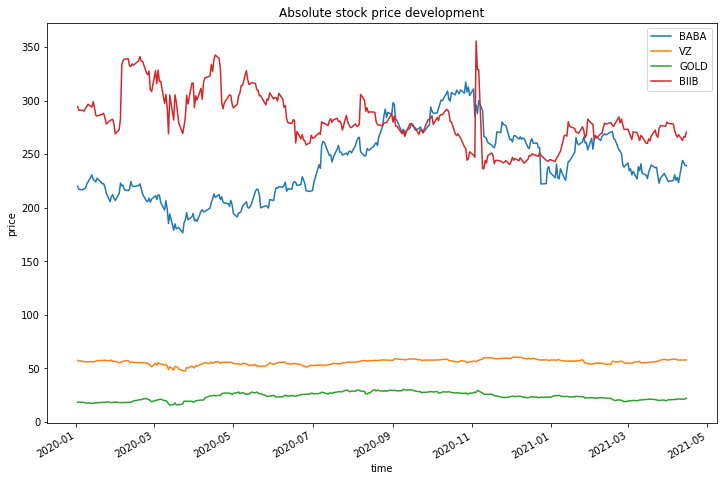

In [374]:
plot_stock_data(data_analysis_df)

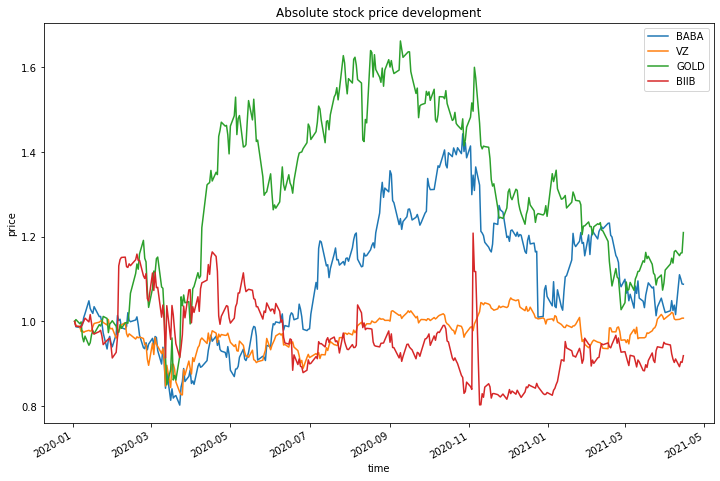

In [375]:
plot_stock_data(data_analysis_norm)

### 3. Feature engineering

In [376]:
# Simple moving average (SMA)

win = 20
sma_20 = data_analysis_norm.rolling(window=win).mean()
std_df = data_analysis_norm.rolling(window=win).std()
sma_20.tail()
std_df.tail()

,BABA,VZ,GOLD,BIIB
2021-04-09,0.022610,0.021670,0.027261,0.021246
2021-04-12,0.026755,0.020557,0.027818,0.021748
2021-04-13,0.029148,0.019170,0.028563,0.020581
2021-04-14,0.029912,0.017405,0.029346,0.019272
2021-04-15,0.030813,0.015326,0.033526,0.018632


In [377]:
# Bollinger(R) Bands

def get_bollinger_bands(rm=sma_20, rstd=std_df):
    upper_band = rm + rstd*2
    lower_band = rm - rstd*2
    return upper_band, lower_band


In [378]:
b_upper_band, b_lower_band = get_bollinger_bands()
b_upper_band.tail()

,BABA,VZ,GOLD,BIIB
2021-04-09,1.091322,1.035578,1.182664,0.959706
2021-04-12,1.102375,1.035536,1.185624,0.960145
2021-04-13,1.109801,1.035008,1.188021,0.958840
2021-04-14,1.114128,1.033795,1.190688,0.957220
2021-04-15,1.117238,1.031858,1.201387,0.957008


In [379]:
# Daily returns

def get_daily_returns(df=data_analysis_df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:]/df[:-1].values) - 1
    daily_returns.iloc[0,:] = 0
    return daily_returns

In [380]:
daily_returns = get_daily_returns()
daily_returns.head()

,BABA,VZ,GOLD,BIIB
2020-01-02,0.000000,0.000000,0.000000,0.000000
2020-01-03,-0.012604,-0.010647,0.004327,-0.011521
2020-01-06,-0.001659,-0.002152,-0.009693,-0.000103
2020-01-07,0.004570,-0.011117,0.004350,-0.002510
2020-01-08,0.001700,0.001846,-0.035192,0.008859


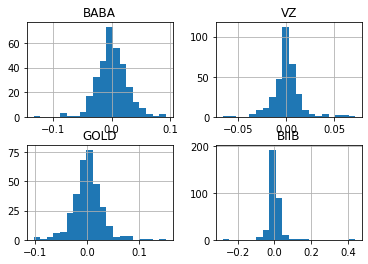

In [381]:
daily_returns.hist(bins= 20)
plt.show()

In [382]:
# MOMENTUM

def get_momentum(df=data_analysis_df, win=5):
    df_momentum = df.copy()
    df_momentum[win:] = (df[win:]/df[:-(win)].values) - 1
    df_momentum.iloc[0:(win),:] = 0
    return df_momentum

In [475]:
momentum = get_momentum()
momentum.tail()

,BABA,VZ,GOLD,BIIB
2021-04-09,-0.004680,-0.003285,0.041237,-0.037817
2021-04-12,0.083045,-0.012077,0.017450,-0.054268
2021-04-13,0.049096,-0.014720,0.010536,-0.020496
2021-04-14,0.061263,-0.011512,0.021287,-0.008320
2021-04-15,0.047538,0.001736,0.038752,0.017725


In [384]:
momentum_10 = get_momentum(win=10)
momentum_10.head(15)

,BABA,VZ,GOLD,BIIB
2020-01-02,0.000000,0.000000,0.000000,0.000000
2020-01-03,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.000000,0.000000,0.000000,0.000000
2020-01-07,0.000000,0.000000,0.000000,0.000000
2020-01-08,0.000000,0.000000,0.000000,0.000000
2020-01-09,0.000000,0.000000,0.000000,0.000000
2020-01-10,0.000000,0.000000,0.000000,0.000000
2020-01-13,0.000000,0.000000,0.000000,0.000000
2020-01-14,0.000000,0.000000,0.000000,0.000000
2020-01-15,0.000000,0.000000,0.000000,0.000000


In [570]:
class StockDataAnalysis():
    ''' Creates a StockDataAnalysis object which is able to take one or mutiple stock symbols and a timeframe and then computes
        a range of indicators on the stock data and plots the results'''
    
    def __init__(self, symbols=['SPY'], start_date='2020-01-01', end_date='2020-12-31', pred_days=7):
        ''' Create an instance of StockDataAnalysis'''
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.pred_days = pred_days
        
        self.data = get_data(self.symbols, self.start_date, self.end_date)
        self.data_norm = normalize_stock_data(self.data)
        
    # Plot stock price data and check for anomalies

    def plot_stock_data(self, normalized=True):
        if normalized:
            df = self.data_norm
            title_str = 'Relative stock price development'
        else:
            df = self.data
            title_str = 'Absolute stock price development'
        if isinstance(df, pd.Series):
            plt.figure(figsize=(12,8))
            ax1 = df.plot()
            ax1.set_xlabel('time')
            ax1.set_ylabel('price')
            ax1.set_title(title_str)
            plt.legend(loc='upper right')
            plt.show()
        else:
            plt.figure(figsize=(12,18))
            ax2 = plt.subplot(2,1,1)
            ax2.set_xlabel('time')
            ax2.set_ylabel('price')
            ax2.set_title(title_str)
            for col in df.columns:
                df[col].plot()
        
            plt.legend(loc='upper right')
           
    def calculate_rolling_stats(self, win=20):
        rm = self.data_norm.rolling(window=win).mean()
        rstd = self.data_norm.rolling(window=win).std()
        self.sma = rm.dropna()
        self.rstd = rstd.dropna()
        
    def calculate_bollinger_bands(self):
        self.upper_band = self.sma + self.rstd*2
        self.lower_band = self.sma - self.rstd*2
            
    def calculate_daily_returns(self):
        daily_returns = self.data.copy()
        daily_returns[1:] = (self.data[1:]/self.data[:-1].values) - 1
        daily_returns.iloc[0,:] = 0
        self.daily_returns = daily_returns
        
    def calculate_momentum(self, win=5):
        self.momentum = self.data.copy()
        self.momentum[win:] = (self.data[win:]/self.data[:-(win)].values) - 1
        self.momentum.iloc[0:(win),:] = 0
        
            
    def create_indicator_dataframe(self):
        ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
            and joins all indicators to one dataframe 
            INPUT: 
            df - dataframe - contains the orginal data to analyse 
            OUTPUT:
            indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
        
        self.indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','SMA','Momentum','Upper Band','Lower Band'])
        
        for symbol in self.data.columns:
            df_temp = self.data[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
            df_temp['Symbol'] = symbol
            df_temp = df_temp.join(self.daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
            df_temp = df_temp.join(self.sma[symbol], on='Date').rename(columns={symbol:'SMA'})
            df_temp = df_temp.join(self.upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
            df_temp = df_temp.join(self.lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
            df_temp = df_temp.join(self.momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})                    

            self.indicator_df = pd.concat([self.indicator_df, df_temp])
            
            self.indicator_df.fillna(method='ffill', inplace=True)
            self.indicator_df.fillna(method='bfill', inplace=True)

        return self.indicator_df
    
    def create_train_test_data(self, symbol='SPY', train_size=0.8):
        ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
            INPUT:
            indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
            symbol - str - symbol of the listed company for which you want to predict stock price
            train_size - float - size of train dataset
            OUTPUT:
            Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            X_train - nd array - contains the training dataset of the independent variables
            X_test - nd array - contains the test dataset of the independent variables
            time_series_train - 1d array - selected time period of training data
            time_series_test - 1d array - selected time period of test data
        '''
        train_data = int(self.indicator_df[self.indicator_df['Symbol']==symbol].shape[0] * train_size)
        test_size = self.indicator_df[self.indicator_df['Symbol']==symbol].shape[0] - train_data

        self.X_train = preprocessing.scale(self.indicator_df[self.indicator_df['Symbol']==symbol].iloc[20:train_data,3:9]) 
        self.X_test = preprocessing.scale(self.indicator_df[self.indicator_df['Symbol']==symbol].iloc[train_data:,3:9])
        self.X_pred = preprocessing.scale(self.indicator_df[self.indicator_df['Symbol']==symbol].iloc[-(self.pred_days):,3:9])
        self.Y_train = self.indicator_df[self.indicator_df['Symbol']==symbol].iloc[20:train_data,2].values
        self.Y_test = self.indicator_df[self.indicator_df['Symbol']==symbol].iloc[train_data:,2].values
        self.time_series_train = self.indicator_df[self.indicator_df['Symbol']==symbol].iloc[20:train_data,0].values
        self.time_series_test = self.indicator_df[self.indicator_df['Symbol']==symbol].iloc[train_data:,0].values

            
        

In [586]:
st_data = StockDataAnalysis(['AHLA.DE','ABR.F','CFSL.F', 'BN9.F'], '2007-01-01', '2021-04-20',12)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


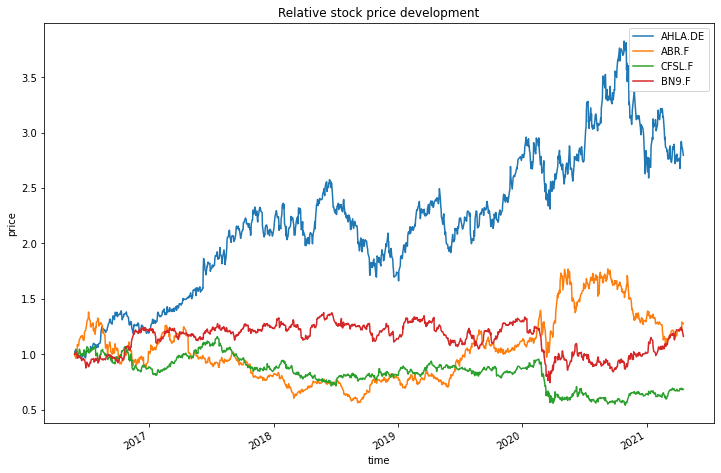

In [587]:
st_data.plot_stock_data()

In [588]:
st_data.calculate_rolling_stats()

In [589]:
st_data.calculate_bollinger_bands()


In [590]:
st_data.calculate_daily_returns()

In [591]:
st_data.calculate_momentum()


In [592]:
st_data.create_indicator_dataframe()
st_data.indicator_df

,Date,Symbol,Adj Close,Daily Returns,SMA,Momentum,Upper Band,Lower Band
0,2016-05-26,AHLA.DE,69.779999,0.000000,0.994354,0.000000,1.040660,0.948048
1,2016-05-27,AHLA.DE,71.750000,0.028232,0.994354,0.000000,1.040660,0.948048
2,2016-05-30,AHLA.DE,72.889999,0.015888,0.994354,0.000000,1.040660,0.948048
3,2016-05-31,AHLA.DE,72.440002,-0.006174,0.994354,0.000000,1.040660,0.948048
4,2016-06-01,AHLA.DE,71.580002,-0.011872,0.994354,0.000000,1.040660,0.948048
...,...,...,...,...,...,...,...,...
1236,2021-04-13,BN9.F,41.139999,0.009818,1.194727,0.020590,1.257290,1.132163
1237,2021-04-14,BN9.F,40.270000,-0.021147,1.196724,0.004239,1.259679,1.133768
1238,2021-04-15,BN9.F,40.490002,0.005463,1.198925,0.007214,1.262677,1.135173
1239,2021-04-16,BN9.F,39.990002,-0.012349,1.200885,-0.005719,1.263415,1.138354


In [594]:
st_data.create_train_test_data('ABR.F')
st_data.X_pred

array([[ 0.32285723, -1.77645654, -1.70103963, -0.88973428, -2.12986766],
       [ 0.52508811, -1.37127414,  0.66671609, -0.99720411, -0.94467792],
       [ 0.58247019, -0.92678739,  1.12279176, -0.85355829, -0.23382016],
       [-1.18812973, -0.61950637, -0.52430874, -0.87653264,  0.53312526],
       [ 0.54202296, -0.3193709 ,  1.08926136, -0.62328148,  0.66105182],
       [-0.0751324 , -0.02280787,  0.70488127, -0.30765483,  0.64012003],
       [-0.97805069,  0.22587613, -0.73072022, -0.16965874,  0.90798742],
       [-0.32690446,  0.47741836, -1.57416364, -0.03851766,  1.19795281],
       [-0.59795515,  0.51743624, -1.01776162,  0.00822637,  1.18576917],
       [ 2.64572779,  0.92976488,  0.92370307,  0.95746961,  0.00661838],
       [-0.50843145,  1.29493009,  0.50344541,  1.66814332, -0.7447608 ],
       [-0.9435624 ,  1.59077753,  0.53719491,  2.12230271, -1.07949836]])

## II. MACHINE LEARNING PIPELINE
### 1. Merge different indicators to one dataframe per symbol 

In [385]:
def create_indicator_dataframe(df):
    ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
        and joins all indicators to one dataframe 
        INPUT: 
        df - dataframe - contains the orginal data to analyse 
        OUTPUT:
        indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
    indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','SMA','Momentum_5', 'Momentum_10','Upper Band','Lower Band'])
    
    for symbol in df.columns:
        df_temp = df[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
        df_temp['Symbol']= symbol

        df_temp = df_temp.join(daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
        df_temp = df_temp.join(sma_20[symbol], on='Date').rename(columns={symbol:'SMA'})
        df_temp = df_temp.join(b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
        df_temp = df_temp.join(b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
        df_temp = df_temp.join(momentum_5[symbol], on='Date').rename(columns={symbol:'Momentum_5'})
        df_temp = df_temp.join(momentum_10[symbol], on='Date').rename(columns={symbol:'Momentum_10'})
        indicator_df = pd.concat([indicator_df, df_temp])
        
        indicator_df.fillna(method='ffill', inplace=True)
        indicator_df.fillna(method='bfill', inplace=True)
    
    return indicator_df
        

In [386]:
indicator_model_df = create_indicator_dataframe(data_analysis_df)
indicator_model_df

,Date,Symbol,Adj Close,Daily Returns,SMA,Momentum_5,Momentum_10,Upper Band,Lower Band
0,2020-01-02,BABA,219.770004,0.000000,0.996919,0.000000,0.000000,1.057098,0.936741
1,2020-01-03,BABA,217.000000,-0.012604,0.996919,0.000000,0.000000,1.057098,0.936741
2,2020-01-06,BABA,216.639999,-0.001659,0.996919,0.000000,0.000000,1.057098,0.936741
3,2020-01-07,BABA,217.630005,0.004570,0.996919,0.000000,0.000000,1.057098,0.936741
4,2020-01-08,BABA,218.000000,0.001700,0.996919,0.000000,0.000000,1.057098,0.936741
...,...,...,...,...,...,...,...,...,...
319,2021-04-09,BIIB,268.170013,0.009182,0.917214,-0.037817,-0.021170,0.959706,0.874722
320,2021-04-12,BIIB,262.799988,-0.020025,0.916648,-0.054268,-0.049995,0.960145,0.873151
321,2021-04-13,BIIB,266.190002,0.012900,0.917678,-0.020496,-0.035823,0.958840,0.876516
322,2021-04-14,BIIB,265.790009,-0.001503,0.918675,-0.008320,-0.037028,0.957220,0.880131


### 2. Create train and test data and standardize

In [387]:
def create_train_test_data(indicator_df, symbol, train_size=0.8):
    ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
        INPUT:
        indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
        symbol - str - symbol of the listed company for which you want to predict stock price
        train_size - float - size of train dataset
        OUTPUT:
        Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        X_train - nd array - contains the training dataset of the independent variables
        X_test - nd array - contains the test dataset of the independent variables
        time_series_train - 1d array - selected time period of training data
        time_series_test - 1d array - selected time period of test data
    '''
    train_data = int(indicator_df[indicator_df['Symbol']==symbol].shape[0] * train_size)
    test_size = indicator_df[indicator_df['Symbol']==symbol].shape[0] - train_data

    X_train = preprocessing.scale(indicator_df[indicator_df['Symbol']==symbol].iloc[20:train_data,3:9]) 
    X_test = preprocessing.scale(indicator_df[indicator_df['Symbol']==symbol].iloc[train_data:,3:9])
    Y_train = indicator_df[indicator_df['Symbol']==symbol].iloc[20:train_data,2].values
    Y_test = indicator_df[indicator_df['Symbol']==symbol].iloc[train_data:,2].values
    time_series_train = indicator_df[indicator_df['Symbol']==symbol].iloc[20:train_data,0].values
    time_series_test = indicator_df[indicator_df['Symbol']==symbol].iloc[train_data:,0].values

    return X_train, X_test, Y_train, Y_test , time_series_train, time_series_test
    

In [388]:
X_train, X_test, Y_train, Y_test , time_series_train, time_series_test = create_train_test_data(indicator_model_df, symbol='GOLD', train_size=0.7)

### 3. Setup model



In [390]:
# Setup different models (regressors)

knn = KNeighborsRegressor(n_neighbors=4)  #weights='distance'
#model = AdaBoostRegressor(base_estimator=knn, random_state=42)
model = RandomForestRegressor(random_state=42, criterion='mae', n_estimators=50, min_samples_split=8)

model.fit(X_train, Y_train)
Y_predict = model.predict(X_test)


In [409]:
# Evaluate model performance and plot data
def evaluate_model_performance(Y_test, Y_predict, time_series_test):
    ''' '''
    rmse = np.sqrt(np.sum((Y_test - Y_predict) **2)/len(Y_predict)) #(root mean squared error)
    corr = np.corrcoef(x=Y_test, y=Y_predict)
    
    fig = plt.figure(figsize=(12,8))

    plt.plot(time_series_test, Y_test, color='lightblue', linewidth=2, label='test data')
    plt.plot(time_series_test, Y_predict, color='red',  linewidth=2, label='predicted data')
    plt.legend()
    
    return rmse, corr
    

(3.572549538121108,
 array([[1.        , 0.78116646],
        [0.78116646, 1.        ]]))

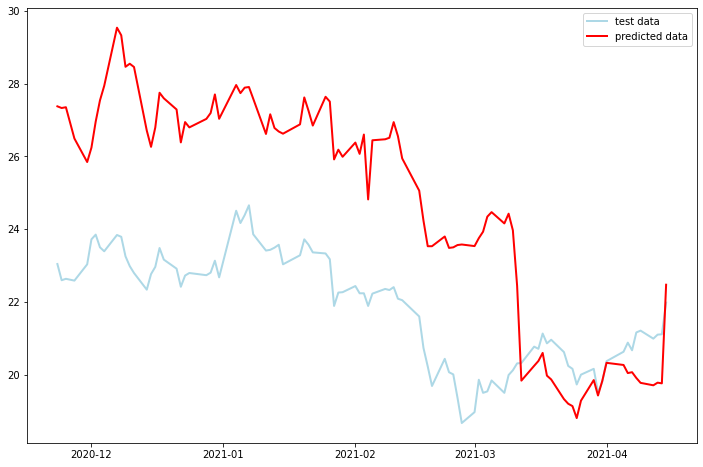

In [410]:
evaluate_model_performance(Y_test, Y_predict, time_series_test)

In [595]:
class ModelStockPrice():
    def __init__(self):
        '''Create an instance of the model to predict stockprice'''
        self.knn = KNeighborsRegressor(weights='distance')
        
        # self.model = AdaBoostRegressor(base_estimator=self.knn, random_state=42)
        self.model = RandomForestRegressor(random_state=42, criterion='mae',
                                             n_estimators=30, min_samples_split=5)

    def fit(self, stockdata):
        '''Fit the model with training data '''
        self.model.fit(stockdata.X_train, stockdata.Y_train)

    def predict(self, stockdata):
        '''Predict stockprice '''
        return self.model.predict(stockdata.X_pred)
    
    def evaluate_model_performance(self, stockdata, Y_pred):
        '''Evaluate prediction'''
        rmse = np.sqrt(np.sum((stockdata.Y_test - Y_predict) **2)/len(Y_predict)) #(root mean squared error)
        corr = np.corrcoef(x=stockdata.Y_test, y=Y_predict)
    
        fig = plt.figure(figsize=(12,8))

        plt.plot(stockdata.time_series_test, stockdata.Y_test, color='lightblue', linewidth=2, label='test data')
        plt.plot(stockdata.time_series_test, Y_pred, color='red',  linewidth=2, label='predicted data')
        plt.legend()
    
        return rmse, corr

In [596]:
price_reg = ModelStockPrice()

In [597]:
price_reg.fit(st_data)

In [598]:
Y_predict = price_reg.predict(st_data)
Y_predict

array([ 9.38219396, 10.72175132, 11.61802464, 11.41250375, 11.81988921,
       13.655921  , 13.65338321, 13.81894531, 13.88720145, 15.60855338,
       15.63239846, 17.82469727])

In [584]:
price_reg.evaluate_model_performance(st_data, Y_predict)

ValueError: operands could not be broadcast together with shapes (249,) (7,) 